In [1]:
import pymc as pm
import matplotlib.pyplot as plt
from scipy.stats import beta
import numpy as np
import pandas as pd
import arviz as az
from scipy.optimize import fmin
import openpyxl

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
np.random.seed(1234)

### Odtworzony przykład z wykładu

In [28]:
def simulate_factory(factory, n_batches):
    """
    Symuluje działanie fabryki przez n_batches kroków.
    
    Zwraca:
    - Lista skumulowanych sukcesów.
    - Lista wskaźników sukcesów w czasie.
    """
    cumulative_successes = []
    success_rates = []

    for _ in range(n_batches):
        factory.get_element()
        cumulative_successes.append(factory.good)
        success_rates.append(factory.good / factory.systems)

    return cumulative_successes, success_rates

In [29]:
def plot_beta(factory, plot_name: str):
    fig, ax = plt.subplots()
    for idx, batch in enumerate(factory.batches):
        alpha, beta_val = batch.alpha, batch.beta
        x = np.linspace(beta.ppf(0.000001, alpha, beta_val),
                        beta.ppf(0.999999, alpha, beta_val), 100)
        y = beta.pdf(x, alpha, beta_val)
        ax.plot(x, y, label=f'#{idx}, quality = {batch.quality}')
        ax.fill_between(x, y, alpha=0.25)

    ax.set_title(plot_name)
    ax.legend()
    plt.show()

In [30]:
class Batch:
    """
    Klasa Batch reprezentuje pojedynczą partię produkcyjną z przypisaną jakością i historią sukcesów/porażek.
    Używa rozkładu Beta do modelowania prawdopodobieństwa sukcesu na podstawie obserwacji.
    """
    quality = 0.5  # Początkowa jakość partii (rzeczywiste prawdopodobieństwo sukcesu)
    alpha = 1  # Parametr alfa rozkładu Beta (liczba sukcesów + 1)
    beta = 1   # Parametr beta rozkładu Beta (liczba porażek + 1)

    def __init__(self, quality):
        """
        Inicjalizuje obiekt Batch z podaną jakością.
        """
        self.quality = quality

    def sample_distribution(self):
        """
        Generuje próbkę z rozkładu Beta dla aktualnych wartości alfa i beta.
        Pozwala oszacować prawdopodobieństwo sukcesu na podstawie dotychczasowych obserwacji.
        """
        return np.random.beta(self.alpha, self.beta)

    def get_element(self):
        """
        Symuluje wybór pojedynczego elementu z partii.
        Na podstawie rzeczywistej jakości partii (self.quality) losowo decyduje, czy element jest "dobry" czy "zły".
        Następnie aktualizuje parametry alfa i beta na podstawie wyniku (sukces/porażka).
        """
        # Symulacja sukcesu/porażki na podstawie rzeczywistej jakości
        good = np.random.rand() < self.quality

        # Aktualizacja parametrów rozkładu Beta:
        # - Dodanie sukcesu do alfa, jeśli element był dobry
        # - Dodanie porażki do beta, jeśli element był zły
        self.alpha = self.alpha + int(good)
        self.beta = self.beta + 1 - int(good)

        return good

In [31]:
class Factory:
    """
    Klasa Factory reprezentuje fabrykę, która zarządza wieloma partiami produkcyjnymi.
    Używa rozkładu Beta partii do podejmowania decyzji o wyborze najlepszej partii w danym momencie.
    """
    batches = []  # Lista partii produkcyjnych (Batch)
    systems = 0   # Liczba przetworzonych elementów
    good = 0      # Liczba "dobrych" elementów (sukcesów)

    def set_batches(self, qualities):
        """
        Inicjalizuje fabrykę z listą partii o podanych jakościach.
        """
        # Tworzenie obiektów Batch na podstawie listy jakości
        self.batches = [Batch(quality) for quality in qualities]
        
        # Reset liczników
        self.systems = 0
        self.good = 0

    def get_element(self):
        """
        Symuluje wybór jednej partii do pobrania elementu, na podstawie aktualnych rozkładów Beta.
        Wybiera partię o największym przewidywanym prawdopodobieństwie sukcesu.
        Pobiera element z wybranej partii i aktualizuje liczniki sukcesów i przetworzonych elementów.
        """
        # Pobranie próbek z rozkładów Beta dla każdej partii
        samples = [batch.sample_distribution() for batch in self.batches]
        
        # Wybranie partii z najwyższą wartością próbki
        choice = np.argmax(samples)
        
        # Pobranie elementu z wybranej partii (aktualizacja parametrów partii)
        result = self.batches[choice].get_element()
        
        # Aktualizacja liczników fabryki:
        # - Liczba przetworzonych elementów
        self.systems = self.systems + 1
        # - Liczba "dobrych" elementów (sukcesów)
        self.good = self.good + int(result)

In [32]:
def run_factory(systems, qualities = [0.1, 0.3, 0.8, 0.9]):
    factory = Factory()
    factory.set_batches(qualities)
    for _ in range(systems):
        factory.get_element()
    print(f'Score is {factory.good / factory.systems}')
    return factory

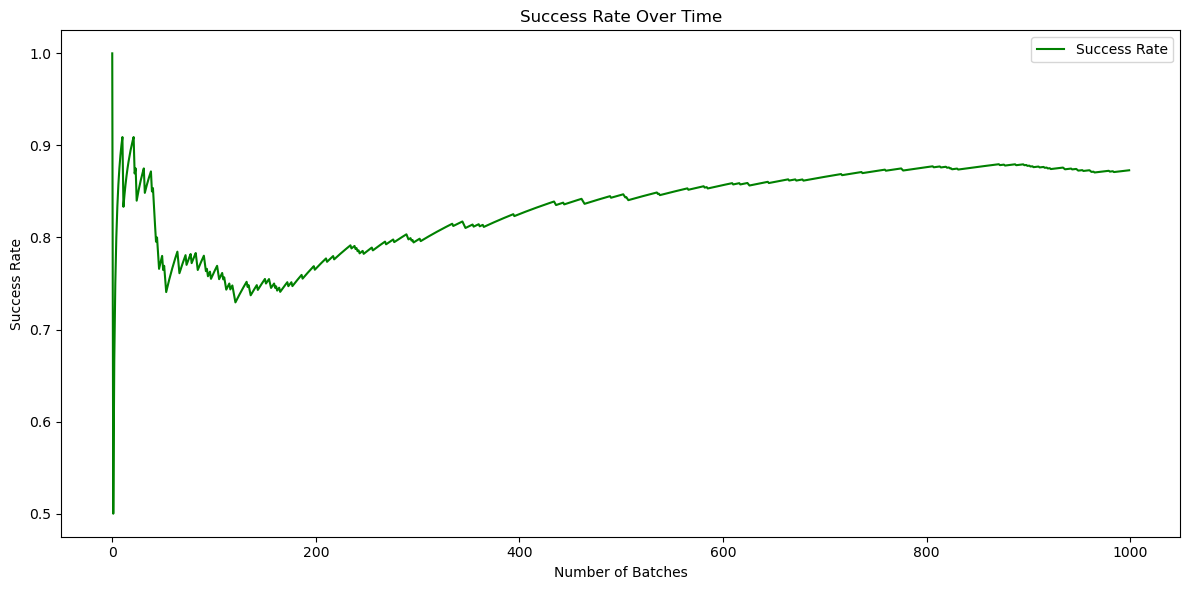

In [42]:
# Definicja jakości partii
qualities = [0.1, 0.3, 0.8, 0.9]

# Tworzenie fabryki i ustawienie partii
test_factory_1 = Factory()
test_factory_1.set_batches(qualities)

# Liczba etapów do symulacji
n_batches = 1000

# Rysowanie wykresów
cumulative_successes, success_rates_base = simulate_factory(test_factory_1, n_batches)

plt.figure(figsize=(12, 6))
# Wskaźnik sukcesów w czasie
plt.plot(range(n_batches), success_rates_base, label='Success Rate', color='green')
plt.title("Success Rate Over Time")
plt.xlabel("Number of Batches")
plt.ylabel("Success Rate")
plt.legend()

plt.tight_layout()
plt.show()


Score is 0.8
Score is 0.8
Score is 0.8
Score is 0.88


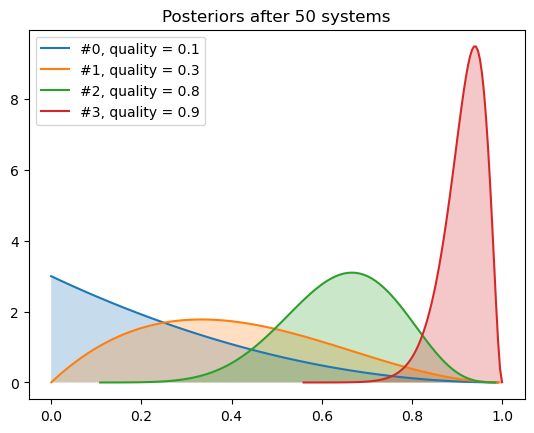

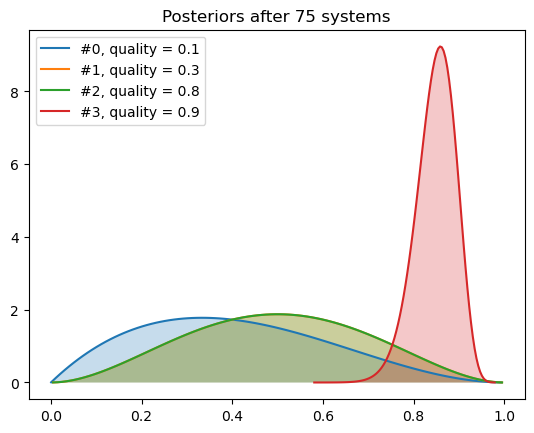

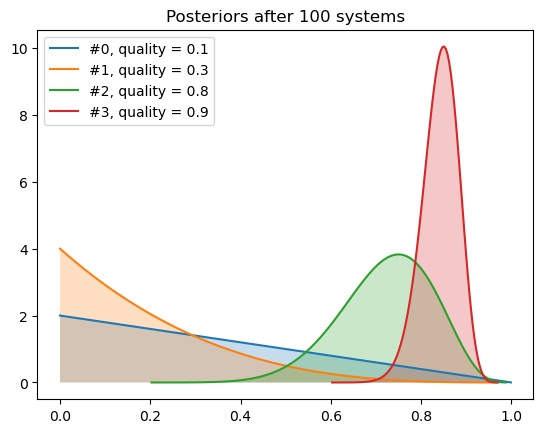

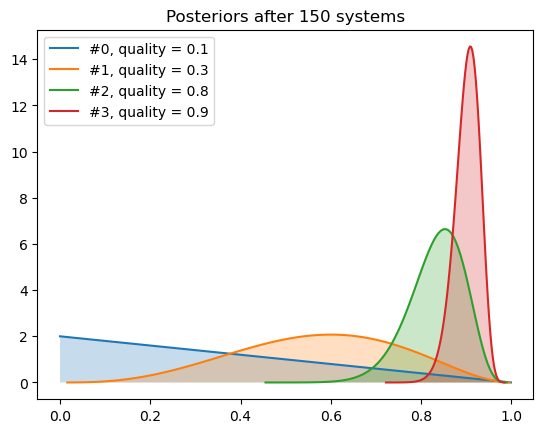

In [9]:
factory_50 = run_factory(systems=50)
factory_75 = run_factory(systems=75)
factory_100 = run_factory(systems=100)
factory_150 = run_factory(systems=150)

plot_beta(factory_50, 'Posteriors after 50 systems')
plot_beta(factory_75, 'Posteriors after 75 systems')
plot_beta(factory_100, 'Posteriors after 100 systems')
plot_beta(factory_150, 'Posteriors after 150 systems')

### Implementacja różnych strategii

In [10]:
def best_so_far(_, choices, success_rates):
    """
    Wybiera producenta z najwyższym stosunkiem sukcesów do prób.
    """
    if not choices:
        return np.random.randint(0, len(success_rates))
    
    total_counts = [choices.count(i) for i in range(len(success_rates))]
    success_counts = [choices[:i+1].count(i) for i in range(len(success_rates))]
    success_ratios = [sc / tc if tc > 0 else 0 for sc, tc in zip(success_counts, total_counts)]
    return np.argmax(success_ratios)

def best_so_far_no_repeat(_, choices, success_rates):
    """
    Wybiera producenta z najwyższym stosunkiem sukcesów do prób, 
    ale unika wybierania tego samego dwa razy z rzędu.
    """
    if not choices:
        # Jeśli wskaźniki wyborów są puste, wybierz losowo producenta.
        return np.random.randint(0, len(success_rates))
    
    #Oblicza całkowitą liczbę prób dla każdego producenta.
    total_counts = [choices.count(i) for i in range(len(success_rates))]

    #Oblicza liczbę sukcesów dla każdego producenta (liczone na podstawie wcześniejszych wyborów).
    success_counts = [choices[:i+1].count(i) for i in range(len(success_rates))]

    #Oblicza stosunek sukcesów do prób (zabezpieczenie przed dzieleniem przez 0).
    success_ratios = [sc / tc if tc > 0 else 0 for sc, tc in zip(success_counts, total_counts)]

    #Pobiera ostatni wybór z listy `choices`.
    last_choice = choices[-1] if choices else None

    #Zwraca listę producentów, których można wybrać (z wyłączeniem ostatniego wyboru).
    eligible_choices = [
        i for i in range(len(success_rates)) if i != last_choice
    ]

    if not eligible_choices:
        #Jeśli nie ma innych opcji, wybierz losowo (np. tylko jeden producent jest dostępny).
        return np.random.randint(0, len(success_rates))

    # Wybierz producenta z najwyższym stosunkiem sukcesów do prób spośród dostępnych opcji.
    best_choice = max(eligible_choices, key=lambda i: success_ratios[i])

    return best_choice

def lemon_avoidance(_, choices, success_rates):
    """
    Unika producentów z niską jakością na podstawie poprzednich wyników.
    """
    if not choices:
        return np.random.randint(0, len(success_rates))
    
    last_choice = choices[-1]
    if np.random.rand() > success_rates[last_choice]:
        return (last_choice + 1) % len(success_rates)
    return last_choice

def ranking_strategy(_, choices, success_rates):
    """
    Wybór producenta na podstawie rankingu prawdopodobieństwa sukcesu.
    """
    total_counts = [choices.count(i) for i in range(len(success_rates))]
    success_counts = [choices[:i+1].count(i) for i in range(len(success_rates))]
    success_ratios = [sc / tc if tc > 0 else 0 for sc, tc in zip(success_counts, total_counts)]
    sorted_indices = np.argsort(success_ratios)[::-1]
    ranks = [len(success_rates) - sorted_indices.tolist().index(i) for i in range(len(success_rates))]
    return np.random.choice(len(success_rates), p=np.array(ranks) / sum(ranks))

In [11]:
# Definicja klasy rozszerzonej FactoryWithStrategy
class FactoryWithStrategy(Factory):
    def __init__(self, strategy_fn):
        super().__init__()
        self.strategy_fn = strategy_fn

    def get_element_with_strategy(self, i):
        """
        Wybiera partię do pobrania elementu zgodnie z podaną strategią.
        """
        # Wybór partii na podstawie strategii
        choice = self.strategy_fn(
            i,
            [batch.alpha / (batch.alpha + batch.beta) for batch in self.batches],
            self.good,
        )
        result = self.batches[choice].get_element()
        self.systems += 1
        self.good += int(result)
        return result

In [12]:
def simulate_strategy(strategy_fn, success_rates, n_batches):
    """
    Funkcja symuluje strategię.
    """
    successes = 0
    choices = []
    for i in range(n_batches):
        choice = strategy_fn(i, choices, success_rates)
        outcome = np.random.rand() < success_rates[choice]
        successes += int(outcome)
        choices.append(choice)
    return successes, choices


In [13]:
def plot_strategy_results(strategies, success_rates, n_batches):
    """
    Rysuje dwa wykresy dla różnych strategii:
    1. Skumulowane sukcesy.
    2. Średni wskaźnik sukcesu w czasie.
    
    Zwraca:
    - Listę wyników w postaci (strategia, running_success_rate).
    """
    # Wyniki symulacji
    results = {}
    running_success_rates_list = []  # Lista do przechowywania (strategia, running_success_rate)

    # Wykonanie symulacji dla każdej strategii
    for name, strategy_fn in strategies.items():
        # Symulacja strategii
        successes, choices = simulate_strategy(strategy_fn, success_rates, n_batches)
        cumulative_successes = np.cumsum([np.random.rand() < success_rates[choice] for choice in choices])
        running_success_rate = [
            np.mean([np.random.rand() < success_rates[choices[j]] for j in range(i + 1)])
            for i in range(n_batches)
        ]
        results[name] = (cumulative_successes, running_success_rate, successes)
        
        # Dodaj do listy wyników
        running_success_rates_list.append((name, running_success_rate))

    # Rysowanie wykresów
    plt.figure(figsize=(12, 6))
    # Średni wskaźnik sukcesu w czasie
    for name, (_, running_success_rate, _) in results.items():
        plt.plot(range(n_batches), running_success_rate, label=name)
    plt.title("Success Rate Over Time by Strategy")
    plt.xlabel("Number of Batches")
    plt.ylabel("Success Rate")
    plt.legend()

    # Wyświetlenie wykresów
    plt.tight_layout()
    plt.show()
    
    # Zwracamy listę strategii i running_success_rate
    return running_success_rates_list


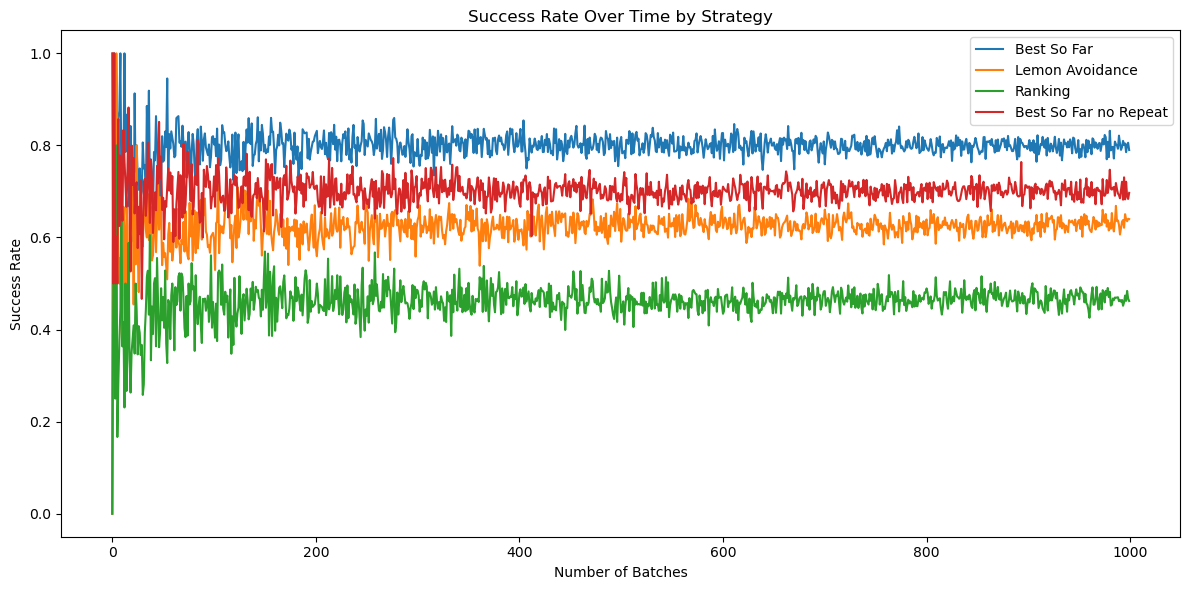

In [14]:
qualities = [0.8, 0.6, 0.4, 0.3]
n_batches = 1000

strategies = {
    "Best So Far": best_so_far,
    "Lemon Avoidance": lemon_avoidance,
    "Ranking": ranking_strategy,
    "Best So Far no Repeat": best_so_far_no_repeat,
    #"Epsilon Greedy (0.1)": epsilon_greedy,
}

running_success_rates_strategy = plot_strategy_results(strategies, qualities, n_batches)

### Przykład z mechanizmem zapominania

In [15]:
class Batch:
    """
    Klasa Batch reprezentuje pojedynczą partię produkcyjną z przypisaną jakością i historią sukcesów/porażek.
    Używa rozkładu Beta do modelowania prawdopodobieństwa sukcesu na podstawie obserwacji.
    """
    def __init__(self, quality = 0.5, gamma=0.99):
        """
        Inicjalizuje obiekt Batch z podaną jakością.
        """
        self.alpha = 1          # Parametr alfa rozkładu Beta (liczba sukcesów + 1)
        self.beta = 1           # Parametr beta rozkładu Beta (liczba porażek + 1)
        self.gamma = gamma      # Parametr gamma (zapominanie)
        self.quality = quality  # Początkowa jakość partii (rzeczywiste prawdopodobieństwo sukcesu)

    def sample_distribution(self):
        """
        Generuje próbkę z rozkładu Beta dla aktualnych wartości alfa i beta.
        Pozwala oszacować prawdopodobieństwo sukcesu na podstawie dotychczasowych obserwacji.
        """
        return np.random.beta(self.alpha, self.beta)

    def get_element(self):
        """
        Symuluje wybór pojedynczego elementu z partii.
        Na podstawie rzeczywistej jakości partii (self.quality) losowo decyduje, czy element jest "dobry" czy "zły".
        Następnie aktualizuje parametry alfa i beta na podstawie wyniku (sukces/porażka).
        """
        # Symulacja sukcesu/porażki na podstawie rzeczywistej jakości
        good = np.random.rand() < self.quality

        # Aktualizacja parametrów rozkładu Beta:
        # - Dodanie sukcesu do alfa, jeśli element był dobry
        # - Dodanie porażki do beta, jeśli element był zły
        old_alpha = self.alpha
        old_beta = self.beta

        self.alpha = self.gamma * old_alpha + int(good)
        self.beta = self.gamma * old_beta + (1 - int(good))

        '''
        Wersja podstawowa:
        self.alpha = self.alpha + int(good)
        self.beta = self.beta + 1 - int(good)
        '''
        '''
        Wersja błędna:
        self.alpha = self.alpha * self.gamma + (1 - self.gamma) * int(good)
        self.beta = self.beta * self.gamma + (1 - self.gamma) * (1 - int(good))
        '''
        return good

In [16]:
class FactoryGamma:
    """
    Klasa Factory zarządza wieloma partiami produkcyjnymi.
    Umożliwia wybór najlepszej partii do produkcji na podstawie rozkładów Beta,
    przy jednoczesnym uwzględnieniu mechanizmu zapominania.
    """
    def __init__(self, qualities, gamma=0.99):
        self.batches = [Batch(q, gamma) for q in qualities]
        self.total_systems = 0
        self.total_successes = 0
        self.success_history = []

    def run_factory(self, n_systems):
        for _ in range(n_systems):
            samples = [b.sample_distribution() for b in self.batches]
            choice = np.argmax(samples)
            result = self.batches[choice].get_element()
            self.total_systems += 1
            self.total_successes += int(result)
            self.success_history.append(self.total_successes / self.total_systems)

In [17]:
def get_best_gamma(qualities, n_systems):
    results = []  # Lista przechowująca wartości gamma i ich score'y

    for gamma in np.arange(0.01, 1.0, 0.01):
        factory = FactoryGamma(qualities, gamma)
        factory.run_factory(n_systems)
        score = factory.success_history[-1]
        
        # Dodaj gamma i score do listy wyników
        results.append((gamma, score))

    # Wyciągnięcie najlepszego wyniku z listy
    best_gamma, best_score = max(results, key=lambda x: x[1])
    
    return results, best_gamma, best_score

def plot_results(results):
    # Rozpakowanie wartości gamma i score z listy rezultatów
    gammas, scores = zip(*results)
    
    # Tworzenie wykresu
    plt.figure(figsize=(10, 6))
    plt.plot(gammas, scores, label="Score dla gamma", marker="o", linestyle="-", color="b")
    
    # Dostosowanie osi i etykiet
    plt.title("Wyniki w zależności od wartości gamma", fontsize=16)
    plt.xlabel("Gamma", fontsize=14)
    plt.ylabel("Score", fontsize=14)
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.legend(fontsize=12)
    
    # Wyświetlenie wykresu
    plt.show()

In [23]:
# Definicja jakości partii
qualities = [0.1, 0.3, 0.8, 0.9]

# Liczba etapów do symulacji
n_systems = 1000
results, best_gamma, best_score = get_best_gamma(qualities, n_systems)
print(f'Best gamma: {best_gamma}, with score: {best_score}')

Best gamma: 0.97, with score: 0.902


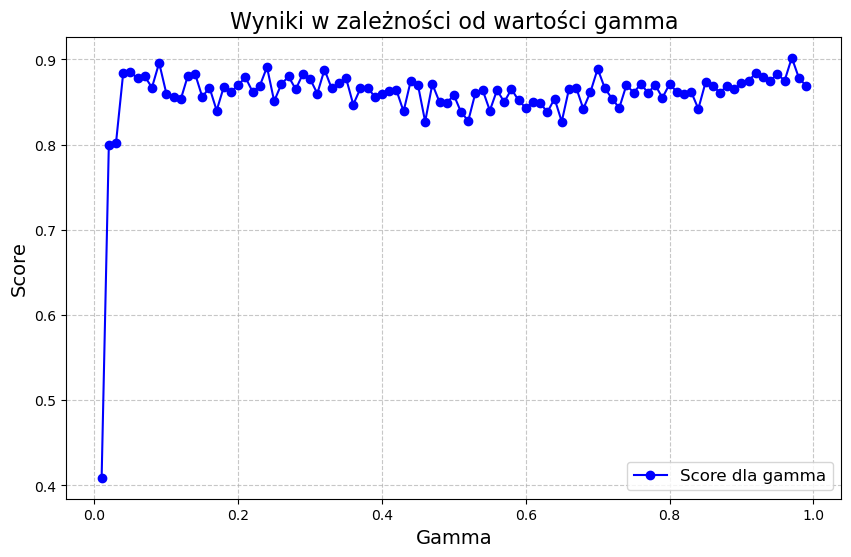

In [24]:
plot_results(results)

In [25]:
factory_gamma_best = FactoryGamma(qualities, gamma=best_gamma)
factory_gamma_best.run_factory(n_systems)
factory_gamma_02 = FactoryGamma(qualities, gamma=0.2)
factory_gamma_02.run_factory(n_systems)
factory_gamma_04 = FactoryGamma(qualities, gamma=0.4)
factory_gamma_04.run_factory(n_systems)
factory_gamma_07 = FactoryGamma(qualities, gamma=0.7)
factory_gamma_07.run_factory(n_systems)


success_rates_best = factory_gamma_best.success_history
success_rates_02 = factory_gamma_02.success_history
success_rates_04 = factory_gamma_04.success_history
success_rates_07 = factory_gamma_07.success_history

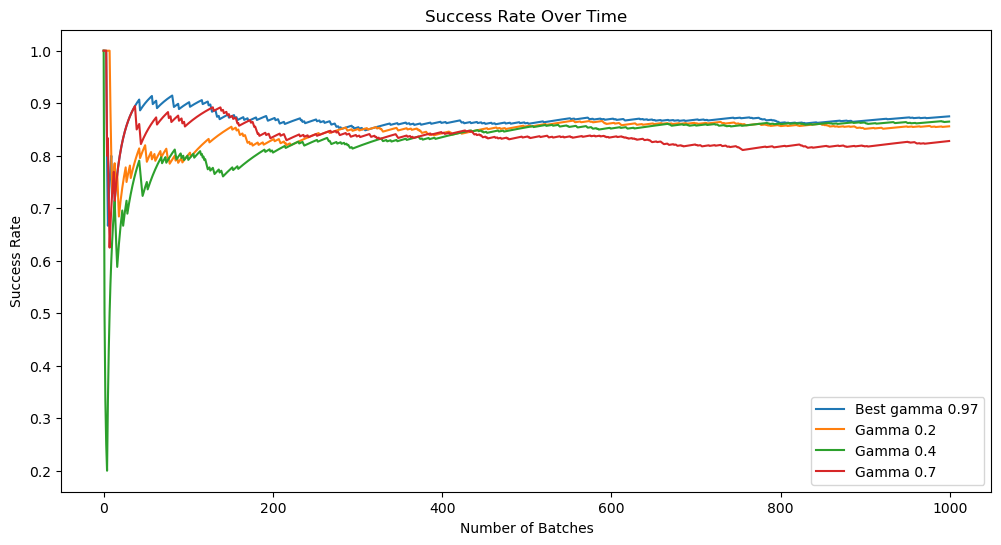

In [26]:
plt.figure(figsize=(12, 6))
plt.plot(success_rates_best, label=f'Best gamma {best_gamma}')
plt.plot(success_rates_02, label='Gamma 0.2')
plt.plot(success_rates_04, label='Gamma 0.4')
plt.plot(success_rates_07, label='Gamma 0.7')
plt.title("Success Rate Over Time")
plt.xlabel("Number of Batches")
plt.ylabel("Success Rate")
plt.legend()
plt.show()

Wartość gamma wskazana przez algorytm w porównaniu z innymi przykładowymi wartościami osiąga lepsze wyniki

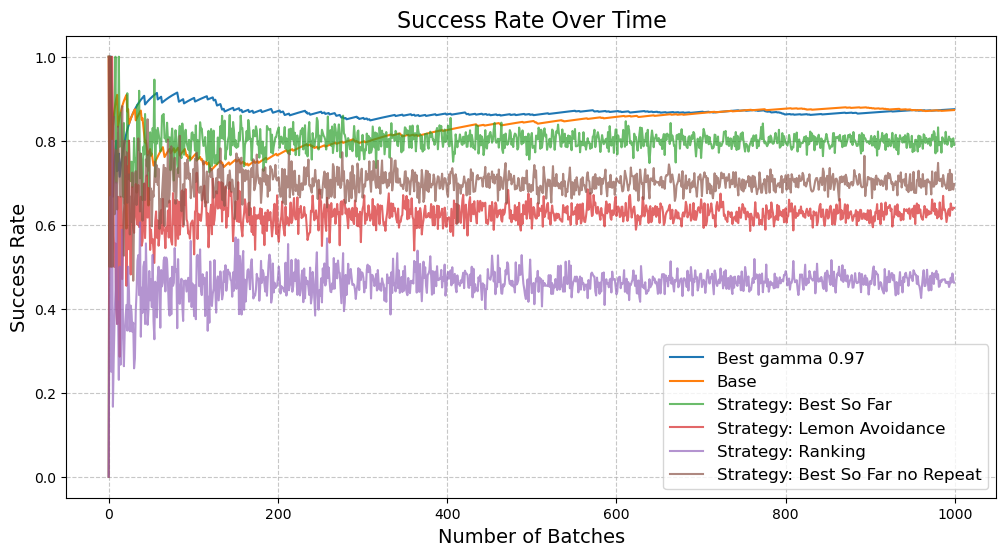

In [43]:
plt.figure(figsize=(12, 6))
plt.plot(success_rates_best, label=f'Best gamma {best_gamma}')
plt.plot(success_rates_base, label='Base')
# Dodanie wyników z różnych strategii
for strategy, running_success_rate in running_success_rates_strategy:
    plt.plot(running_success_rate, label=f"Strategy: {strategy}", linestyle='-', alpha=0.7)

# Dostosowanie wykresu
plt.title("Success Rate Over Time", fontsize=16)
plt.xlabel("Number of Batches", fontsize=14)
plt.ylabel("Success Rate", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)

# Wyświetlenie wykresu
plt.show()